# US News World Report Analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv

from IPython.display import Image
def draw(A):
    return Image(A.draw(format='png', prog='dot'))

In [4]:
import sys
from pathlib import Path
home = str(Path.home())

sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
sys.path.insert(0,"%s/RPLib"%home)

In [5]:
import pyrankability

In [6]:
import pyrplib

In [7]:
years = list(range(2002,2002+1))

In [8]:
colleges = """
Amherst College
Bowdoin College
Carleton College
Claremont McKenna College
Davidson College
Haverford College
Middlebury College
Pomona College
Swarthmore College
Wellesley College
Williams College
""".strip().split('\n')
colleges

['Amherst College',
 'Bowdoin College',
 'Carleton College',
 'Claremont McKenna College',
 'Davidson College',
 'Haverford College',
 'Middlebury College',
 'Pomona College',
 'Swarthmore College',
 'Wellesley College',
 'Williams College']

In [9]:
pd.Series(colleges)

0               Amherst College
1               Bowdoin College
2              Carleton College
3     Claremont McKenna College
4              Davidson College
5             Haverford College
6            Middlebury College
7                Pomona College
8            Swarthmore College
9             Wellesley College
10             Williams College
dtype: object

In [10]:
data = {}
for year in years:
    data[year] = pd.read_excel('data/USNews liberal arts 2002-2016.xls',sheet_name=str(year))
    data[year]['School Name'] = data[year]['School Name'].str.replace('!','')
    data[year]['State'] = data[year]['State'].str.replace('\(','').str.replace('\)','')
    df = pd.DataFrame(list(data[year]['SAT/ACT 25th-75th Percentile'].str.split('-')),columns=['SAT/ACT 25th Percentile','SAT/ACT 75th Percentile'])
    data[year] = pd.concat([data[year],df],axis=1)
    data[year] = data[year].infer_objects()
    data[year]['SAT/ACT 25th-75th Percentile Mean'] = (data[year]['SAT/ACT 25th Percentile'].astype(int)+data[year]['SAT/ACT 75th Percentile'].astype(int))/2


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [11]:
student_columns = {}
parent_columns = {}

In [12]:
columns = list(data[2002].columns)
student_columns[2002] = [columns[13],columns[16],columns[22],columns[9],columns[11]]
student_columns[2002]

['Selectivity Rank',
 'Acceptance Rate',
 'SAT/ACT 25th-75th Percentile Mean',
 'Percent of Classes with Less Than 20 Students',
 'Student/Faculty Ratio']

In [13]:
parent_columns[2002] = [columns[6],columns[9],columns[11],columns[13],columns[16]]
parent_columns[2002]

['Actual 6-year Graduation Rate',
 'Percent of Classes with Less Than 20 Students',
 'Student/Faculty Ratio',
 'Selectivity Rank',
 'Acceptance Rate']

Do we have all the colleges? 

In [14]:
sum(data[2002]['School Name'].isin(colleges)) == len(colleges)

True

## Transform all the columns so they are the same direction as Final Rank column

In [15]:
data2 = {}
for year in years:
    data2[year] = data[year].set_index('School Name')
    data2[year] = data2[year].loc[colleges]

In [16]:
from sklearn.pipeline import Pipeline
Ds = pd.DataFrame(columns=['Year','Group','D']).set_index(['Year','Group'])
for year in years:
    parent_pipe = Pipeline([('fix_sign', pyrplib.transformers.ColumnDirectionTransformer('Final Rank')),
                            ('count_transformer', pyrplib.transformers.ColumnCountTransformer(parent_columns[year]))
                    ])

    student_pipe = Pipeline([('fix_sign', pyrplib.transformers.ColumnDirectionTransformer('Final Rank')),
                            ('count_transformer', pyrplib.transformers.ColumnCountTransformer(student_columns[year]))
                    ])
    
    both_columns = list(set(parent_columns[year]+student_columns[year]))

    both_pipe = Pipeline([('fix_sign', pyrplib.transformers.ColumnDirectionTransformer('Final Rank')),
                            ('count_transformer', pyrplib.transformers.ColumnCountTransformer(both_columns))
                    ])

    parent_pipe.fit(data2[year])
    D = parent_pipe.transform(data2[year])
    Ds = Ds.append(pd.Series([D],index=['D'],name=(year,'Parent')))
    
    student_pipe.fit(data2[year])
    D = student_pipe.transform(data2[year])
    Ds = Ds.append(pd.Series([D],index=['D'],name=(year,'Student')))
    
    both_pipe.fit(data2[year])
    D = both_pipe.transform(data2[year])
    Ds = Ds.append(pd.Series([D],index=['D'],name=(year,'Both')))

In [17]:
Ds.loc[(2002,'Both'),'D']

,Amherst College,Bowdoin College,Carleton College,Claremont McKenna College,Davidson College,Haverford College,Middlebury College,Pomona College,Swarthmore College,Wellesley College,Williams College
School Name1,,,,,,,,,,,
Amherst College,0.0,5.0,4.0,6.0,5.0,5.0,3.0,4.0,3.0,6.0,4.0
Bowdoin College,1.0,0.0,4.0,4.0,5.0,3.0,2.0,3.0,1.0,5.0,1.0
Carleton College,2.0,2.0,0.0,3.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0
Claremont McKenna College,0.0,2.0,3.0,0.0,4.0,4.0,1.0,3.0,0.0,4.0,1.0
Davidson College,1.0,1.0,3.0,2.0,0.0,1.0,2.0,2.0,1.0,4.0,1.0
Haverford College,1.0,3.0,4.0,2.0,5.0,0.0,3.0,2.0,2.0,6.0,2.0
Middlebury College,3.0,4.0,4.0,5.0,4.0,3.0,0.0,3.0,2.0,5.0,3.0
Pomona College,2.0,3.0,4.0,3.0,4.0,4.0,3.0,0.0,2.0,5.0,3.0
Swarthmore College,3.0,5.0,5.0,6.0,5.0,4.0,4.0,4.0,0.0,6.0,4.0


In [18]:
Ds.loc[(2002,'Student'),'D']

,Amherst College,Bowdoin College,Carleton College,Claremont McKenna College,Davidson College,Haverford College,Middlebury College,Pomona College,Swarthmore College,Wellesley College,Williams College
School Name1,,,,,,,,,,,
Amherst College,0.0,4.0,3.0,5.0,4.0,4.0,2.0,3.0,2.0,5.0,3.0
Bowdoin College,1.0,0.0,3.0,3.0,5.0,3.0,1.0,2.0,1.0,4.0,1.0
Carleton College,2.0,2.0,0.0,2.0,3.0,2.0,1.0,1.0,1.0,3.0,2.0
Claremont McKenna College,0.0,2.0,3.0,0.0,4.0,4.0,1.0,2.0,0.0,4.0,1.0
Davidson College,1.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0
Haverford College,1.0,2.0,3.0,1.0,4.0,0.0,2.0,1.0,1.0,5.0,2.0
Middlebury College,3.0,4.0,4.0,4.0,4.0,3.0,0.0,2.0,2.0,5.0,3.0
Pomona College,2.0,3.0,4.0,3.0,4.0,4.0,3.0,0.0,2.0,5.0,3.0
Swarthmore College,3.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,0.0,5.0,4.0


In [19]:
Ds.loc[(2002,'Parent'),'D']

,Amherst College,Bowdoin College,Carleton College,Claremont McKenna College,Davidson College,Haverford College,Middlebury College,Pomona College,Swarthmore College,Wellesley College,Williams College
School Name1,,,,,,,,,,,
Amherst College,0.0,4.0,3.0,5.0,4.0,4.0,3.0,4.0,3.0,5.0,4.0
Bowdoin College,1.0,0.0,4.0,4.0,4.0,2.0,2.0,3.0,1.0,4.0,1.0
Carleton College,2.0,1.0,0.0,3.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0
Claremont McKenna College,0.0,1.0,2.0,0.0,3.0,3.0,1.0,3.0,0.0,3.0,1.0
Davidson College,1.0,1.0,3.0,2.0,0.0,1.0,2.0,2.0,1.0,4.0,1.0
Haverford College,1.0,3.0,4.0,2.0,4.0,0.0,3.0,2.0,2.0,5.0,2.0
Middlebury College,2.0,3.0,3.0,4.0,3.0,2.0,0.0,3.0,2.0,4.0,2.0
Pomona College,1.0,2.0,3.0,2.0,3.0,3.0,2.0,0.0,1.0,4.0,2.0
Swarthmore College,2.0,4.0,4.0,5.0,4.0,3.0,3.0,4.0,0.0,5.0,3.0


## Nearest and farthest from Centroid for combined columns, parent, and student

In [20]:
class Details:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
for index in Ds.index:
    D = Ds.loc[index,'D']
    delta_cont, details_cont = pyrankability.rank.solve(D,method='lop',cont=True)
    delta_bin, details_bin = pyrankability.rank.solve(D,method='lop',cont=False)
    Ds.loc[index,'delta_cont'] = delta_cont
    Ds.loc[index,'delta_bin'] = delta_bin
    Ds.loc[index,'details_cont'] = Details(**details_cont)
    Ds.loc[index,'details_bin'] = Details(**details_bin)
    _, details_fixed_cont_x_maximize = pyrankability.search.solve_fixed_cont_x(D,details_bin['obj'],details_cont['x'],method='lop',minimize=False)
    _, details_fixed_cont_x_minimize = pyrankability.search.solve_fixed_cont_x(D,details_bin['obj'],details_cont['x'],method='lop',minimize=True)    
    Ds.loc[index,'details_fixed_cont_x_maximize'] = Details(**details_fixed_cont_x_maximize)
    Ds.loc[index,'details_fixed_cont_x_minimize'] = Details(**details_fixed_cont_x_minimize)
    

Using license file /home/jupyter-pander14/gurobi.lic
Academic license - for non-commercial use only - expires 2021-04-12


## Look at the continuous results

In [21]:
def plot_xstars(Ds,show_score_xstar2_func=lambda xstars: pyrankability.plot.show_score_xstar2(xstars,
                                                                     group_label="Group",width=300,height=300,
                                                                     columns=1,resolve_scale=True)):
    label = "A"
    xstars = {}
    for index in Ds.index:
        D = Ds.loc[index,'D']
        xstar = pd.DataFrame(Ds.loc[index,'details_cont'].x,index=D.index,columns=D.columns)
        xstars["%s. %s"%(label,", ".join(str(v) for v in index[::-1]))] = xstar
        label = chr(ord(label)+1)
    g,score_df,ordered_xstars = show_score_xstar2_func(xstars)
    return g,score_df,ordered_xstars

In [22]:
g,_,_ = plot_xstars(Ds)
g

alt.FacetChart(...)

## Compare centroids for max and min for each group

In [23]:
pd.Series(Ds.loc[(2002,'Both'),'D'].index)

0               Amherst College
1               Bowdoin College
2              Carleton College
3     Claremont McKenna College
4              Davidson College
5             Haverford College
6            Middlebury College
7                Pomona College
8            Swarthmore College
9             Wellesley College
10             Williams College
Name: School Name1, dtype: object

In [24]:
colleges

['Amherst College',
 'Bowdoin College',
 'Carleton College',
 'Claremont McKenna College',
 'Davidson College',
 'Haverford College',
 'Middlebury College',
 'Pomona College',
 'Swarthmore College',
 'Wellesley College',
 'Williams College']

In [25]:
Ds.loc[(2002,'Parent'),'details_fixed_cont_x_minimize'].perm

(0, 8, 10, 6, 1, 3, 7, 5, 4, 9, 2)

In [26]:
def perm_to_series(D,perm,name):
    return pd.Series(list(D.index[list(perm)]),name=name)

### Parent

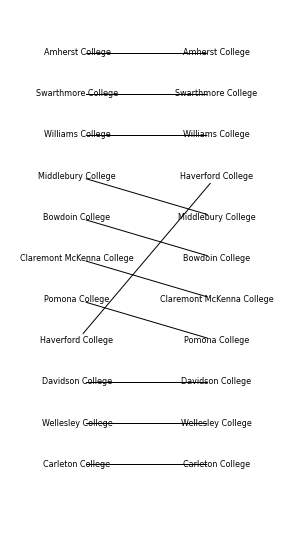

In [27]:
A = perm_to_series(Ds.loc[(2002,'Parent'),'D'],Ds.loc[(2002,'Parent'),'details_fixed_cont_x_minimize'].perm,'Closest')
B = perm_to_series(Ds.loc[(2002,'Parent'),'D'],Ds.loc[(2002,'Parent'),'details_fixed_cont_x_maximize'].perm,'Farthest')
pyrankability.plot.spider2(A,B,file="results/parent_fixed_cont_x_minimize_maximize.png")

### Student

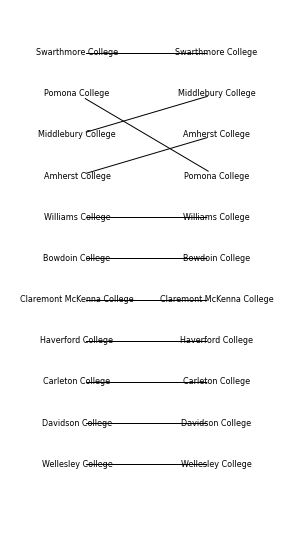

In [28]:
A = perm_to_series(Ds.loc[(2002,'Student'),'D'],Ds.loc[(2002,'Student'),'details_fixed_cont_x_minimize'].perm,'Closest')
B = perm_to_series(Ds.loc[(2002,'Student'),'D'],Ds.loc[(2002,'Student'),'details_fixed_cont_x_maximize'].perm,'Farthest')
pyrankability.plot.spider2(A,B,file="results/student_fixed_cont_x_minimize_maximize.png")

### Both

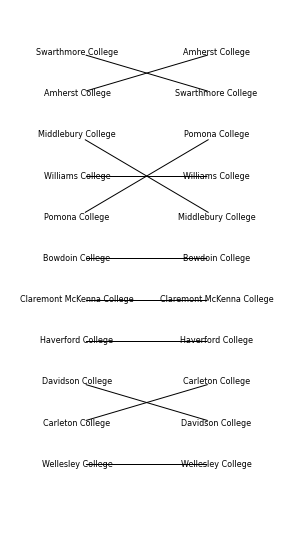

In [29]:
A = perm_to_series(Ds.loc[(2002,'Both'),'D'],Ds.loc[(2002,'Both'),'details_fixed_cont_x_minimize'].perm,'Closest')
B = perm_to_series(Ds.loc[(2002,'Both'),'D'],Ds.loc[(2002,'Both'),'details_fixed_cont_x_maximize'].perm,'Farthest')
pyrankability.plot.spider2(A,B,file="results/both_fixed_cont_x_minimize_maximize.png")

### Now let's consider the centroid to a ranking of interest (Final rank)

In [30]:
data2[2002]['Final Rank'].argsort()

School Name
Amherst College               0
Bowdoin College               8
Carleton College             10
Claremont McKenna College     9
Davidson College              1
Haverford College             2
Middlebury College            5
Pomona College                7
Swarthmore College            6
Wellesley College             4
Williams College              3
Name: Final Rank, dtype: int64

In [31]:
data2[2002]['Final Rank']

School Name
Amherst College               1
Bowdoin College               5
Carleton College              5
Claremont McKenna College    17
Davidson College             10
Haverford College             5
Middlebury College            9
Pomona College                5
Swarthmore College            1
Wellesley College             4
Williams College              3
Name: Final Rank, dtype: int64

In [32]:
data2[2002]['Final Rank'].iloc[data2[2002]['Final Rank'].argsort()]

School Name
Amherst College               1
Swarthmore College            1
Williams College              3
Wellesley College             4
Bowdoin College               5
Carleton College              5
Haverford College             5
Pomona College                5
Middlebury College            9
Davidson College             10
Claremont McKenna College    17
Name: Final Rank, dtype: int64

In [33]:
perm_final_rank = data2[2002]['Final Rank'].argsort()
x_final_rank = pyrankability.common.perm_to_x(perm_final_rank)

In [34]:
index = (2002,'Student')
D = Ds.loc[index,'D']
delta_bin, details_bin = pyrankability.rank.solve(D,method='lop',cont=False)
_, details_fixed_binary_x_maximize = pyrankability.search.solve_fixed_binary_x(D,details_bin['obj'],x_final_rank,method='lop',minimize=False)
_, details_fixed_binary_x_minimize = pyrankability.search.solve_fixed_binary_x(D,details_bin['obj'],x_final_rank,method='lop',minimize=True)    

### Maximize (farthest)

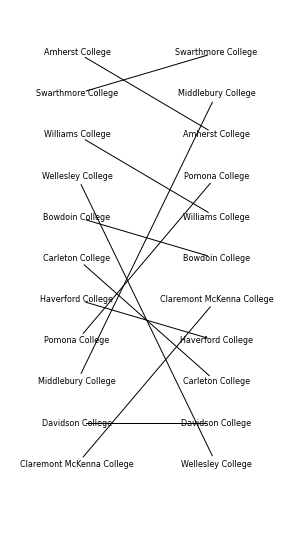

In [35]:
A = perm_to_series(D,perm_final_rank,'Final Rank')
B = perm_to_series(D,details_fixed_binary_x_maximize['perm'],'Farthest')
pyrankability.plot.spider2(A,B,file="results/student_details_fixed_binary_x_maximize.png")

### Minimize (closest)

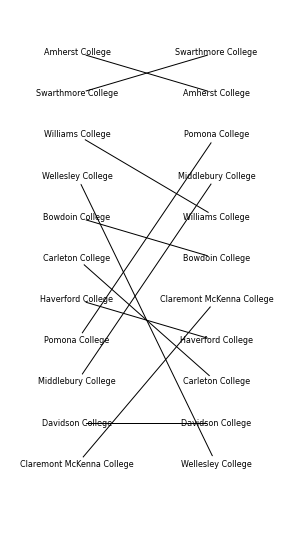

In [36]:
A = perm_to_series(D,perm_final_rank,'Final Rank')
B = perm_to_series(D,details_fixed_binary_x_minimize['perm'],'Closest')
pyrankability.plot.spider2(A,B,file="results/student_details_fixed_binary_x_minimize.png")

### Farthest pair

In [37]:
index = (2002,'Both')
D = Ds.loc[index,'D']
obj, farthest_pair_details = pyrankability.search.solve_pair(D,method='lop',minimize=False)#,min_ndis=None,max_ndis=None,tau_range=None,lazy=False,verbose=True)

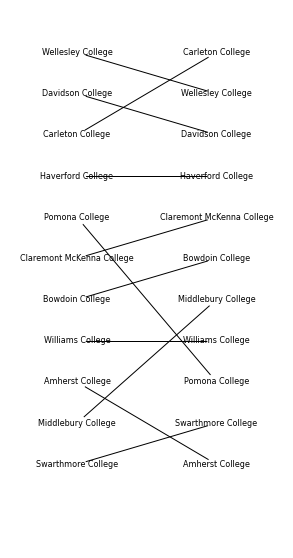

In [38]:
A = perm_to_series(D,farthest_pair_details['perm_x'],'perm_x')
B = perm_to_series(D,farthest_pair_details['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/farthest_pair_{index}.png')

In [39]:
index = (2002,'Both')
D = Ds.loc[index,'D']
obj, nearest_pair_details = pyrankability.search.solve_pair(D,method='lop',minimize=True,min_ndis=1)

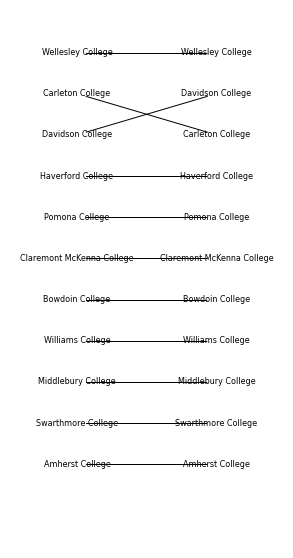

In [40]:
A = perm_to_series(D,nearest_pair_details['perm_x'],'perm_x')
B = perm_to_series(D,nearest_pair_details['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/nearest_pair_{index}.png')

## Two datasets farthest

In [41]:
index = (2002,'Student')
D = Ds.loc[index,'D']
index2 = (2002,'Parent')
D2 = Ds.loc[index,'D']
obj, farthest_pair_details_D_D2 = pyrankability.search.solve_pair(D,D2=D2,method='lop',minimize=False)

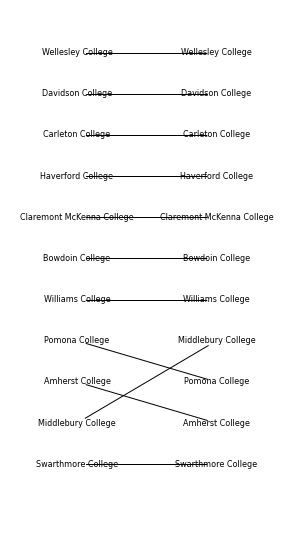

In [42]:
A = perm_to_series(D,farthest_pair_details_D_D2['perm_x'],'perm_x')
B = perm_to_series(D,farthest_pair_details_D_D2['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/farthest_pair_{index}_{index2}.png')

### Student and parent nearest

In [43]:
index = (2002,'Student')
D = Ds.loc[index,'D']
index2 = (2002,'Parent')
D2 = Ds.loc[index,'D']
obj, nearest_pair_details_D_D2 = pyrankability.search.solve_pair(D,D2=D2,method='lop',minimize=True)

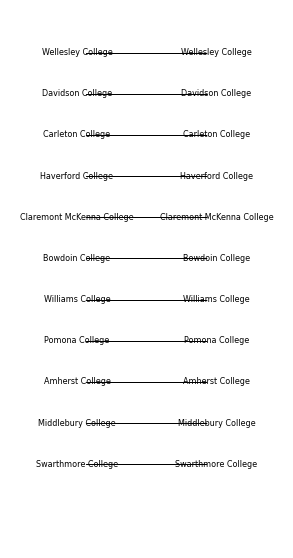

In [44]:
A = perm_to_series(D,nearest_pair_details_D_D2['perm_x'],'perm_x')
B = perm_to_series(D,nearest_pair_details_D_D2['perm_y'],'perm_y')
pyrankability.plot.spider2(A,B,file=f'results/nearest_pair_{index}_{index2}.png')